<a href="https://colab.research.google.com/github/tvani2/Neural-Networks-Facial-Expression-Recognition-Challenge/blob/main/Expr_recognition_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

Install the kaggle python library

In [1]:
!pip install kaggle wandb onnx -Uq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 19.9 MB/s eta 0:00:00


Mount the Google drive so you can store your kaggle API credentials for future use

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Make a directory for kaggle at the temporary instance location on Colab drive.

Download your kaggle API key (.json file). You can do this by going to your kaggle account page and clicking 'Create new API token' under the API section.

In [3]:
! mkdir ~/.kaggle

If you want to copy the kaggle API credentials to the temporary location... (I recommend placing it on your Google Drive)

In [4]:
#! cp kaggle.json ~/.kaggle/

Upload the json file to Google Drive and then copy to the temporary location.

In [5]:
!cp /content/drive/MyDrive/cs231n/assignments/assignment4/kaggle.json ~/.kaggle/kaggle.json

Change the file permissions to read/write to the owner only

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

**Competitions and Datasets are the two types of Kaggle data**

**1. Download competition data**

If you get 403 Forbidden error, you need to click 'Late Submission' on the Kaggle page for that competition.

In [7]:
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

 99% 282M/285M [00:03<00:00, 33.9MB/s]
100% 285M/285M [00:03<00:00, 81.3MB/s]


Unzip, in case the downloaded file is zipped. Refresh the files on the left hand side to update the view.

In [8]:
! unzip challenges-in-representation-learning-facial-expression-recognition-challenge

Archive:  challenges-in-representation-learning-facial-expression-recognition-challenge.zip
  inflating: example_submission.csv  
  inflating: fer2013.tar.gz          
  inflating: icml_face_data.csv      
  inflating: test.csv                
  inflating: train.csv               


In [9]:
import wandb
wandb login --relogin

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: tvani22 (tvani22-free-university-of-tbilisi) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [10]:
run = wandb.init(
    project="Facial_Expression_Recognition_1",
    config={
        "learning_rate": 0.001,
        "epochs": 10,
        "batch_size": 64,
        "optimizer": "Adam",
        "loss_function": "CrossEntropyLoss",
        "architecture": "SimpleCNN",
    }
)

In [11]:
import wandb
import os
import pandas as pd
# Create a wandb artifact
# Reference [1] explains how to create an artifact with a type and project
raw_data_artifact = wandb.Artifact(
    name="facial-expression-dataset",
    type="dataset",
    description="Facial Expression Recognition Challenge Dataset"
)
# Log the artifact to the current run
wandb.log_artifact(raw_data_artifact)

print("Data loaded and logged as a wandb artifact.")

Data loaded and logged as a wandb artifact.


In [12]:
import torch # Main PyTorch Library
from torch import nn # Used for creating the layers and loss function
from torch.optim import Adam # Adam Optimizer
import torchvision.transforms as transforms # Transform function used to modify and preprocess all the images
from torch.utils.data import Dataset, DataLoader # Dataset class and DataLoader for creating the objects
from sklearn.preprocessing import LabelEncoder # Label Encoder to encode the classes from strings to numbers
import matplotlib.pyplot as plt # Used for visualizing the images and plotting the training progress
from PIL import Image # Used to read the images from the directory
import pandas as pd # Used to read/create dataframes (csv) and process tabular data
import numpy as np # preprocessing and numerical/mathematical operations
import os # Used to read the images path from the directory

device = "cuda" if torch.cuda.is_available() else "cpu" # detect the GPU if any, if not use CPU, change cuda to mps if you have a mac
print("Device available: ", device)

Device available:  cpu


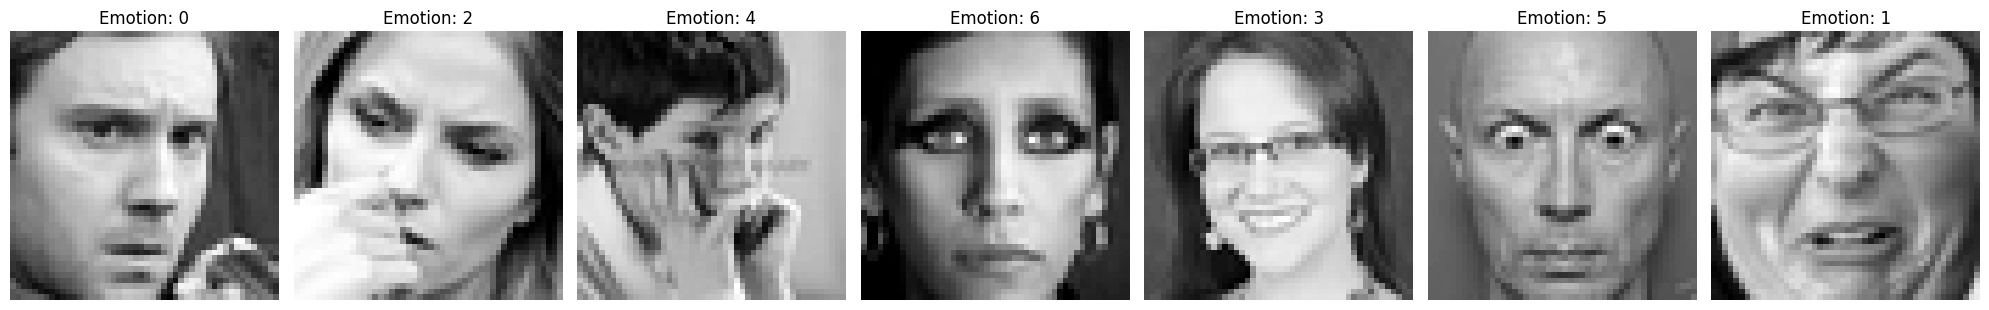

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image # Import Image for potential future use if needed, though not strictly required for this task

# Load the dataset
# Change the file path to the correct location after unzipping
df = pd.read_csv('./train.csv')

# Function to convert pixels string to image array
def pixels_to_image(pixels_str):
    pixels = np.array([int(p) for p in pixels_str.split()], dtype='uint8')
    image = pixels.reshape(48, 48)
    return image

# Get unique emotion labels
emotions = df['emotion'].unique()

# Create a figure and axes for plotting
fig, axes = plt.subplots(1, len(emotions), figsize=(20, 5))

# Iterate through each emotion and display one image
for i, emotion in enumerate(emotions):
    # Find the first row in the DataFrame that has the current emotion
    row = df[df['emotion'] == emotion].iloc[0]

    # Convert the pixels string to an image array
    image = pixels_to_image(row['pixels'])

    # Display the image on the corresponding subplot
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f"Emotion: {emotion}")
    axes[i].axis('off') # Hide the axes

# Adjust layout to prevent titles from overlapping
plt.tight_layout()
plt.show()

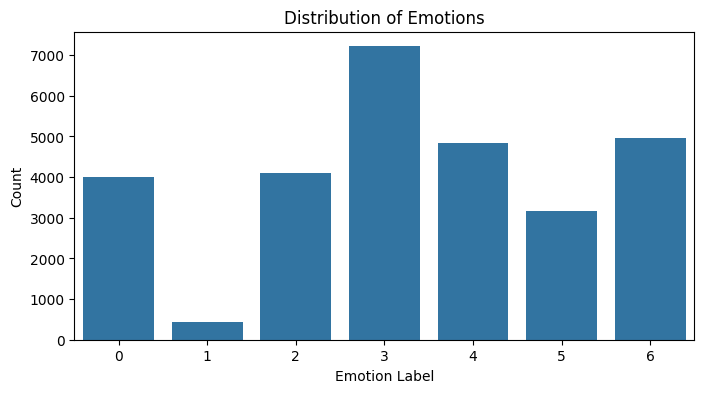

In [14]:
import seaborn as sns

# Countplot of emotion distribution
plt.figure(figsize=(8, 4))
sns.countplot(x='emotion', data=df)
plt.title('Distribution of Emotions')
plt.xlabel('Emotion Label')
plt.ylabel('Count')
plt.show()

In [15]:
import pandas as pd
import numpy as np

# Function to convert pixels string to image array
def pixels_to_image_array(pixels_str):
    """
    Converts a space-separated string of pixel values into a 48x48 NumPy array.

    Args:
        pixels_str (str): A string containing space-separated pixel values.

    Returns:
        numpy.ndarray: A 48x48 NumPy array representing the image.
    """
    # Split the string by spaces, convert each element to an integer,
    # and create a NumPy array of dtype uint8 (unsigned 8-bit integer, standard for pixel values 0-255).
    pixels = np.array(pixels_str.split(), dtype='uint8')

    # Reshape the 1D array into a 48x48 2D array (row major order).
    image = pixels.reshape(48, 48)

    return image

# Apply the function to the 'pixels' column
# This will create a new column (or replace the existing one)
# where each entry is now a 48x48 NumPy array instead of a string.
df['pixels'] = df['pixels'].apply(pixels_to_image_array)

# Display the first few rows to verify the change (optional)
print("DataFrame after converting 'pixels' strings to NumPy arrays:")
print(df.head())

# You can access an image array like this:
# first_image_array = df.iloc[0]['pixels']
# print("\nShape of the first image array:", first_image_array.shape)
# print("Data type of the first image array:", first_image_array.dtype)

DataFrame after converting 'pixels' strings to NumPy arrays:
   emotion                                             pixels
0        0  [[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, ...
1        0  [[151, 150, 147, 155, 148, 133, 111, 140, 170,...
2        2  [[231, 212, 156, 164, 174, 138, 161, 173, 182,...
3        4  [[24, 32, 36, 30, 32, 23, 19, 20, 30, 41, 21, ...
4        6  [[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 2...


In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# --- Split Data ---

# Define the features (X) and labels (y)
# X will be the 'pixels' column (NumPy arrays)
# y will be the 'emotion' column (numerical labels)
X = df['pixels']
y = df['emotion']

# We already know the total training set size is 28709.
# We need to split this into train, validation, and *a new* test set for this process.
# Note: This new test set is drawn from the original *training* data
# and is separate from the test set already provided in the competition.
# It's good practice to hold out a portion of your *original training data*
# as a final evaluation set, especially if the competition doesn't provide
# a public/private split on their test set or if you want more control
# over your final performance estimation.

# Let's choose a split percentage. A common split is 70% train, 15% validation, 15% test
# from the original training data (28709 samples).

train_size = 0.70
val_size = 0.15
test_size = 0.15 # This is for our *new* test set from the original train data

# First, split into training + validation and the new test set
# Use stratify=y to ensure the emotion distribution is preserved
X_temp, X_test_new, y_temp, y_test_new = train_test_split(
    X, y, test_size=test_size, random_state=42, stratify=y
)

# Now, split the temporary set (X_temp, y_temp) into training and validation sets
# The proportion for the validation set is calculated relative to the *temporary* set size.
# val_size / (train_size + val_size) = 0.15 / (0.70 + 0.15) = 0.15 / 0.85
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=(val_size / (train_size + val_size)), random_state=42, stratify=y_temp
)

# Display the sizes of the new sets
print(f"Original Training Data Size: {len(df)}")
print(f"New Training Set Size: {len(X_train)}")
print(f"Validation Set Size: {len(X_val)}")
print(f"New Test Set Size (from original train data): {len(X_test_new)}")

# Optional: Verify the distribution in each set
print("\nEmotion distribution in New Training Set:")
print(y_train.value_counts(normalize=True))

print("\nEmotion distribution in Validation Set:")
print(y_val.value_counts(normalize=True))

print("\nEmotion distribution in New Test Set:")
print(y_test_new.value_counts(normalize=True))

# Note: X_train, X_val, X_test_new now contain pandas Series where each element
# is a 48x48 NumPy array. y_train, y_val, y_test_new are pandas Series
# containing the corresponding integer emotion labels.

Original Training Data Size: 28709
New Training Set Size: 20095
Validation Set Size: 4307
New Test Set Size (from original train data): 4307

Emotion distribution in New Training Set:
emotion
3    0.251356
6    0.172929
4    0.168201
2    0.142672
0    0.139189
5    0.110425
1    0.015228
Name: proportion, dtype: float64

Emotion distribution in Validation Set:
emotion
3    0.251219
6    0.172974
4    0.168331
2    0.142791
0    0.139076
5    0.110518
1    0.015092
Name: proportion, dtype: float64

Emotion distribution in New Test Set:
emotion
3    0.251219
6    0.172974
4    0.168331
2    0.142791
0    0.139076
5    0.110518
1    0.015092
Name: proportion, dtype: float64


In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# --- Convert pandas Series of arrays to single NumPy array ---
# Stack the 48x48 arrays in the Series into a single 3D NumPy array
X_train_np = np.stack(X_train.values)
X_val_np = np.stack(X_val.values)
X_test_new_np = np.stack(X_test_new.values)

# Add a channel dimension (for grayscale images, this will be 1)
# Deep learning frameworks expect image data in the format (batch_size, channels, height, width)
# or (batch_size, height, width, channels). Let's add the channel dimension at the end.
X_train_np = np.expand_dims(X_train_np, axis=-1)
X_val_np = np.expand_dims(X_val_np, axis=-1)
X_test_new_np = np.expand_dims(X_test_new_np, axis=-1)


# --- Normalization Function ---
def normalize_pixels(image_array):
    """
    Scales pixel values from [0, 255] to [0, 1].

    Args:
        image_array (numpy.ndarray): Input image data (can be 2D or 3D/4D array).

    Returns:
        numpy.ndarray: Normalized image data.
    """
    # Ensure the data type is float before division
    # Dividing uint8 by an integer might perform integer division.
    # Dividing uint8 by a float results in float.
    return image_array / 255.0

# --- Apply Normalization ---
X_train_normalized = normalize_pixels(X_train_np)
X_val_normalized = normalize_pixels(X_val_np)
X_test_new_normalized = normalize_pixels(X_test_new_np)


# --- Verification (Optional) ---
print("Original Data Type:", X_train_np.dtype)
print("Normalized Data Type:", X_train_normalized.dtype)
print("Original Min/Max (first image):", X_train_np[0].min(), X_train_np[0].max())
print("Normalized Min/Max (first image):", X_train_normalized[0].min(), X_train_normalized[0].max())

print("\nShape of normalized training data:", X_train_normalized.shape)
print("Shape of normalized validation data:", X_val_normalized.shape)
print("Shape of normalized new test data:", X_test_new_normalized.shape)

# The normalized data is now in these variables:
# X_train_normalized, X_val_normalized, X_test_new_normalized

Original Data Type: uint8
Normalized Data Type: float64
Original Min/Max (first image): 0 208
Normalized Min/Max (first image): 0.0 0.8156862745098039

Shape of normalized training data: (20095, 48, 48, 1)
Shape of normalized validation data: (4307, 48, 48, 1)
Shape of normalized new test data: (4307, 48, 48, 1)


In [18]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split

# --- Convert Normalized NumPy Arrays and Labels to Tensors ---

def convert_to_tensors(image_arrays, labels):
    """
    Converts normalized image NumPy arrays and label Series/arrays to PyTorch tensors.

    Args:
        image_arrays (numpy.ndarray): Normalized image data (e.g., shape [N, H, W, C]).
        labels (pandas.Series or numpy.ndarray): Labels (e.g., shape [N,]).

    Returns:
        tuple: (image_tensors, label_tensors)
               image_tensors (torch.Tensor): Image data as float tensors.
               label_tensors (torch.Tensor): Labels as long tensors.
    """
    # Convert image arrays to float tensors.
    # PyTorch typically expects image tensors in (N, C, H, W) format,
    # while our NumPy arrays are currently (N, H, W, C).
    # We need to permute (rearrange) the dimensions.
    image_tensors = torch.tensor(image_arrays, dtype=torch.float32).permute(0, 3, 1, 2)

    # Convert labels (which might be a pandas Series) to a NumPy array first, then to long tensor.
    # torch.long is used for classification labels in CrossEntropyLoss.
    if isinstance(labels, pd.Series):
        label_tensors = torch.tensor(labels.values, dtype=torch.long)
    else: # Assuming it's already a numpy array
         label_tensors = torch.tensor(labels, dtype=torch.long)


    return image_tensors, label_tensors

# --- Apply Conversion to your Data Splits ---

X_train_tensor, y_train_tensor = convert_to_tensors(X_train_normalized, y_train)
X_val_tensor, y_val_tensor = convert_to_tensors(X_val_normalized, y_val)
X_test_new_tensor, y_test_new_tensor = convert_to_tensors(X_test_new_normalized, y_test_new)


# --- Verification (Optional) ---
print("Shape of training image tensor:", X_train_tensor.shape)
print("Data type of training image tensor:", X_train_tensor.dtype)
print("Shape of training label tensor:", y_train_tensor.shape)
print("Data type of training label tensor:", y_train_tensor.dtype)

print("\nShape of validation image tensor:", X_val_tensor.shape)
print("Shape of validation label tensor:", y_val_tensor.shape)

print("\nShape of new test image tensor:", X_test_new_tensor.shape)
print("Shape of new test label tensor:", y_test_new_tensor.shape)

Shape of training image tensor: torch.Size([20095, 1, 48, 48])
Data type of training image tensor: torch.float32
Shape of training label tensor: torch.Size([20095])
Data type of training label tensor: torch.int64

Shape of validation image tensor: torch.Size([4307, 1, 48, 48])
Shape of validation label tensor: torch.Size([4307])

Shape of new test image tensor: torch.Size([4307, 1, 48, 48])
Shape of new test label tensor: torch.Size([4307])


In [19]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# --- Create Custom Dataset Class ---

class EmotionDataset(Dataset):
    """Custom Dataset for facial emotion data."""

    def __init__(self, images, labels, transform=None):
        """
        Args:
            images (torch.Tensor): Tensor of images (N, C, H, W).
            labels (torch.Tensor): Tensor of labels (N,).
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels) # The number of samples

    def __getitem__(self, idx):
        # Get image and label for the given index
        image = self.images[idx]
        label = self.labels[idx]

        # Apply transform if any (though we've already normalized,
        # this is where augmentation would typically go for train)
        if self.transform:
             pass

        return image, label

# --- Create Datasets ---
train_dataset = EmotionDataset(X_train_tensor, y_train_tensor, transform=None)
val_dataset = EmotionDataset(X_val_tensor, y_val_tensor, transform=None)
test_new_dataset = EmotionDataset(X_test_new_tensor, y_test_new_tensor, transform=None)

In [20]:
# --- Create DataLoaders ---

# Define batch size
batch_size = 64 # A common starting batch size

# Create DataLoaders
# train_dataloader: shuffle=True is important for randomizing batches
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# val_dataloader: shuffle=False - order doesn't matter for evaluation
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# test_new_dataloader: shuffle=False - order doesn't matter for final evaluation
test_new_dataloader = DataLoader(test_new_dataset, batch_size=batch_size, shuffle=False)

print(f"\nBatch size: {batch_size}")
print(f"Number of batches in training dataloader: {len(train_dataloader)}")
print(f"Number of batches in validation dataloader: {len(val_dataloader)}")
print(f"Number of batches in new test dataloader: {len(test_new_dataloader)}")

# --- Optional: Iterate through a batch to see the output format ---
# Get the first batch from the training dataloader
first_batch_images, first_batch_labels = next(iter(train_dataloader))

print("\n--- First Batch from Training Dataloader ---")
print("Shape of image batch:", first_batch_images.shape)
print("Data type of image batch:", first_batch_images.dtype)
print("Shape of label batch:", first_batch_labels.shape)
print("Data type of label batch:", first_batch_labels.dtype)
print("First 10 labels in the batch:", first_batch_labels[:10])


Batch size: 64
Number of batches in training dataloader: 314
Number of batches in validation dataloader: 68
Number of batches in new test dataloader: 68

--- First Batch from Training Dataloader ---
Shape of image batch: torch.Size([64, 1, 48, 48])
Data type of image batch: torch.float32
Shape of label batch: torch.Size([64])
Data type of label batch: torch.int64
First 10 labels in the batch: tensor([3, 4, 4, 2, 2, 3, 3, 4, 3, 1])


In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# --- Define a Very Simple Model Architecture (SimpleCNN) ---

class SimpleCNN(nn.Module):
    """
    A very simple CNN for grayscale 48x48 image classification.
    Architecture: Conv -> ReLU -> Pool -> Conv -> ReLU -> Pool -> Flatten -> Linear
    """
    def __init__(self, num_classes=7):
        """
        Initializes the SimpleCNN model.

        Args:
            num_classes (int): The number of output classes (emotions). Defaults to 7.
        """
        super(SimpleCNN, self).__init__()

        # First convolutional layer
        # Input channels: 1 (grayscale image)
        # Output channels: 16 (number of filters/feature maps)
        # Kernel size: 3x3 (a common small filter size)
        # Padding: 1 (adds a border of 1 pixel around the image, helps maintain spatial dimensions)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)

        # Max pooling layer
        # Kernel size: 2x2 (window size for pooling)
        # Stride: 2 (moves the window 2 steps at a time, effectively halves spatial dimensions)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second convolutional layer
        # Input channels: 16 (output from the previous layer)
        # Output channels: 32 (more filters to learn more complex features)
        # Kernel size: 3x3
        # Padding: 1
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)

        # Fully connected layer (Classifier)
        # Input features: This depends on the output size of the last pooling layer.
        # Let's calculate it:
        # Input Image: 48x48
        # After conv1 (padding 1): spatial size remains 48x48
        # After pool (kernel 2, stride 2): spatial size becomes 48/2 = 24x24
        # After conv2 (padding 1): spatial size remains 24x24
        # After pool (kernel 2, stride 2): spatial size becomes 24/2 = 12x12
        # The number of channels after conv2 is 32.
        # So, the flattened size before the linear layer is 32 * 12 * 12 = 4608
        self.fc1 = nn.Linear(32 * 12 * 12, num_classes)

    def forward(self, x):
        """
        Defines the forward pass of the model.

        Args:
            x (torch.Tensor): Input tensor representing a batch of images (N, 1, 48, 48).

        Returns:
            torch.Tensor: Output tensor representing the raw scores/logits for each class (N, num_classes).
        """
        # Apply first convolution, ReLU activation, and pooling
        x = self.pool(F.relu(self.conv1(x))) # -> N x 16 x 24 x 24

        # Apply second convolution, ReLU activation, and pooling
        x = self.pool(F.relu(self.conv2(x))) # -> N x 32 x 12 x 12

        # Flatten the tensor for the fully connected layer
        # x.view(-1, ...) reshapes the tensor. -1 infers the batch size.
        x = x.view(-1, 32 * 12 * 12)       # -> N x (32*12*12) = N x 4608

        # Apply the fully connected layer
        x = self.fc1(x)                    # -> N x num_classes

        # Note: We don't apply Softmax here. CrossEntropyLoss in PyTorch
        # expects the raw logits (scores) and applies Softmax internally
        # for numerical stability.

        return x

In [22]:
# --- Instantiate the Model ---
num_classes = 7
model = SimpleCNN(num_classes=num_classes)

print(model)

# --- Optional: Move model to device (GPU if available) ---
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
print(f"Model moved to: {device}")
wandb.watch(model, log="all")

SimpleCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4608, out_features=7, bias=True)
)
Model moved to: cpu


In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import wandb # Import wandb

# --- Define Loss Function and Optimizer ---

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# --- Training and Validation Functions ---

def train_epoch(model, dataloader, criterion, optimizer, device):
    """Trains the model for one epoch and logs to wandb."""
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / total_samples
    epoch_accuracy = correct_predictions / total_samples

    # Log training metrics to wandb
    wandb.log({"train_loss": epoch_loss, "train_accuracy": epoch_accuracy})

    return epoch_loss, epoch_accuracy

def validate_epoch(model, dataloader, criterion, device):
    """Validates the model for one epoch and logs to wandb."""
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / total_samples
    epoch_accuracy = correct_predictions / total_samples

    # Log validation metrics to wandb
    wandb.log({"val_loss": epoch_loss, "val_accuracy": epoch_accuracy})

    return epoch_loss, epoch_accuracy

# --- Training Loop ---

num_epochs = 10

print(f"\nStarting training for {num_epochs} epochs...")

for epoch in range(num_epochs):
    train_loss, train_accuracy = train_epoch(model, train_dataloader, criterion, optimizer, device)
    val_loss, val_accuracy = validate_epoch(model, val_dataloader, criterion, device)

    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

print("\nTraining finished.")

# --- Evaluate on New Test Set ---

def evaluate_model(model, dataloader, criterion, device, set_name="Test"):
    """Evaluates the model on a given dataloader and logs test accuracy to wandb."""
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    avg_loss = running_loss / total_samples
    accuracy = correct_predictions / total_samples

    print(f"\n{set_name} Results:")
    print(f"  Loss: {avg_loss:.4f}")
    print(f"  Accuracy: {accuracy:.4f}")

    # Log test accuracy to wandb (optional but good practice)
    wandb.log({f"{set_name.lower().replace(' ', '_')}_loss": avg_loss, f"{set_name.lower().replace(' ', '_')}_accuracy": accuracy})

# Evaluate on the new test set drawn from the original training data
evaluate_model(model, test_new_dataloader, criterion, device, set_name="New Test Set (from original train data)")

# It's good practice to call wandb.finish() when your run is complete
# wandb.finish()


Starting training for 10 epochs...
Epoch 1/10: Train Loss: 1.6859, Train Acc: 0.3294 | Val Loss: 1.6119, Val Acc: 0.3764
Epoch 2/10: Train Loss: 1.5362, Train Acc: 0.4068 | Val Loss: 1.5059, Val Acc: 0.4258
Epoch 3/10: Train Loss: 1.4428, Train Acc: 0.4509 | Val Loss: 1.4327, Val Acc: 0.4532
Epoch 4/10: Train Loss: 1.3631, Train Acc: 0.4865 | Val Loss: 1.4130, Val Acc: 0.4637
Epoch 5/10: Train Loss: 1.3076, Train Acc: 0.5094 | Val Loss: 1.3848, Val Acc: 0.4771
Epoch 6/10: Train Loss: 1.2582, Train Acc: 0.5327 | Val Loss: 1.3805, Val Acc: 0.4757
Epoch 7/10: Train Loss: 1.2201, Train Acc: 0.5461 | Val Loss: 1.3545, Val Acc: 0.4978
Epoch 8/10: Train Loss: 1.1840, Train Acc: 0.5640 | Val Loss: 1.3528, Val Acc: 0.5031
Epoch 9/10: Train Loss: 1.1492, Train Acc: 0.5785 | Val Loss: 1.3732, Val Acc: 0.5003
Epoch 10/10: Train Loss: 1.1209, Train Acc: 0.5874 | Val Loss: 1.3783, Val Acc: 0.4936

Training finished.

New Test Set (from original train data) Results:
  Loss: 1.3816
  Accuracy: 0.4878